
# DQN for an Atari game using OpenAI Gym

## Resources
https://github.com/sudharsan13296/Hands-On-Reinforcement-Learning-With-Python/blob/master/08.%20Atari%20Games%20with%20DQN/8.8%20Building%20an%20Agent%20to%20Play%20Atari%20Games.ipynb
 
https://github.com/chengxi600/RLStuff/blob/master/Q%20Learning/Atari_DQN.ipynb

https://medium.com/nerd-for-tech/reinforcement-learning-deep-q-learning-with-atari-games-63f5242440b1

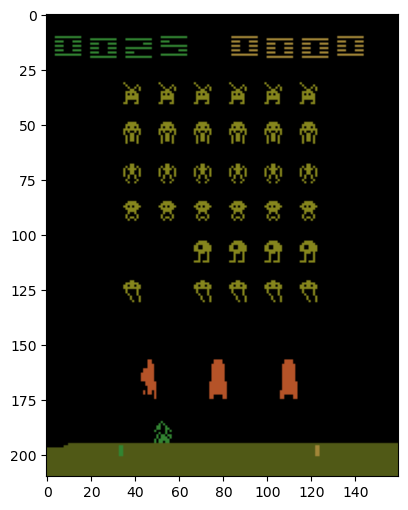

In [ ]:
import matplotlib.pyplot as plt
import gym
from IPython import display

env = gym.make('SpaceInvaders-v4')
env.reset()

fig = plt.figure(figsize=(6, 6))

for i in range(1000):
    obs = env.render(mode='rgb_array')
    plt.imshow(obs)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    env.step(env.action_space.sample()) # take a random action
    
env.close()


The reward in the OpenAI gym environment "SpaceInvaders-v4" is defined as follows:

+1 is awarded for each alien that is shot.
-1 is awarded for each time a player's ship is hit by an alien's bomb.
+100 is awarded for each time a player's ship reaches the bottom of the screen.
The goal of the agent is to maximize the cumulative reward, which is equivalent to shooting as many aliens as possible and avoiding being hit by their bombs.

In [ ]:
import random
import numpy as np
import tensorflow as tf
from collections import deque
from gym import wrappers
import gym
import pickle

# Hyperparameters
#learning_rate = 0.00025
learning_rate = 0.001
discount_factor = 0.99
exploration_max = 1.0
exploration_min = 0.01
exploration_decay = 0.995 # this decay rate is probably too slow

# Initialize the environment
env = gym.make('SpaceInvaders-v4')

# Neural Network Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 8, 4, input_shape=(84, 84, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 4, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, 1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(env.action_space.n, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

# Memory
memory = deque(maxlen=10000)

# preprocess the frame
def preprocess_frame(frame):
    gray = tf.image.rgb_to_grayscale(frame)
    resized = tf.image.resize(gray, [84, 84])
    return np.array(resized)

# choose the next action
def choose_action(state, exploration_rate):
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    q_values = model.predict(state)
    return np.argmax(q_values[0])

# store the experience in the memory
def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# learn from the experiences
def experience_replay(batch_size):
    # Check if there are enough memories stored
    if len(memory) < batch_size:
        return
    #sample a batch of memories
    samples = random.sample(memory, batch_size)
    # update values for each memory iteration
    for state, action, reward, next_state, done in samples:
        q_update = reward
        if not done:
            next_state = next_state.reshape(1, 84, 84, 4)
            #Calculate the discounted future reward
            q_update = (reward + discount_factor * np.amax(model.predict(next_state)[0]))
        state = state.reshape(1, 84, 84, 4)
         # Get the current Q-values for the state 
        q_values = model.predict(state)
        # Update the Q-value for the chosen action 
        q_values[0][action] = q_update
        # Fit the model to the updated Q-values S/A
        model.fit(state, q_values, verbose=0)

# update the exploration rate
def update_exploration_rate(exploration_rate):
    return max(exploration_min, exploration_rate * exploration_decay)

# Training
total_steps = 0
exploration_rate = exploration_max
# List to store total rewards for each episode
rewards = []

#List to store exploration rate for each episode
exploration_rates = []

# Warm-up period
# Collect experiences without learning from them until the memory buffer is filled
warmup_steps = 100
while len(memory) < warmup_steps:
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0

    while not done:
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_max)
        next_state, reward, done,_ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1


for episode in range(1, 5000):
    state = env.reset() # reset state
    state = preprocess_frame(state) # process frames
    # Stack the preprocessed state 4 times
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0
    
    while not done:
        #choose action
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_rate)
        # take step action and observe outcome 
        next_state, reward, done, _ = env.step(action)
        # process next state
        next_state = preprocess_frame(next_state)
        # concatenate to last 3 states to create new state stack
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        # add experience to the buffer
        store_experience(state, action, reward, next_state, done)
        state = next_state
        # update the Q-network by replaying batch of experiences
        experience_replay(batch_size=2000) 
        total_steps += 1
        
    exploration_rate = update_exploration_rate(exploration_rate)        
    print("Episode: {}/{}, Exploration rate: {:.4f}, Total reward: {}".format(episode, 5000, exploration_rate, total_reward))

    # Append the total reward and exploration rate for this episode to the respective lists
    rewards.append(total_reward)
    exploration_rates.append(exploration_rate)
        

    env.close()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
Episode: 942/5000, Exploration rate: 0.0100, Total reward: 25.0
1/1 [==============================] - 0s 19ms/step
Episode: 943/5000, Exploration rate: 0.0100, Total reward: 10.0
1/1 [==============================] - 0s 24ms/step
Episode: 944/5000, Exploration rate: 0.0100, Total reward: 30.0
1/1 [==============================] - 0s 21ms/step
Episode: 945/5000, Exploration rate: 0.0100, Total reward: 5.0
1/1 [==============================] - 0s 20ms/step
Episode: 946/5000, Exploration rate: 0.0100, Total reward: 30.0
1/1 [==============================] - 0s 19ms/step
Episode: 947/5000, Exploration rate: 0.0100, Total reward: 10.0
1/1 [==============================] - 0s 26ms/step
Episode: 948/5000, Exploration rate: 0.0100, Total reward: 15.0
1/1 [==============================] - 0s 19ms/step


possible that the increasing RAM usage is due to a memory leak in the code which could be the accumulation of TensorFlow graphs in memory. Clearing the TensorFlow graph at the end of each episode to try and solve the high ram issue

a low batch size results in the experience replay getting stuck in that state and unable to complete an episode while having a deque that can store too many experiences can impact performace due to ram and cause a crash

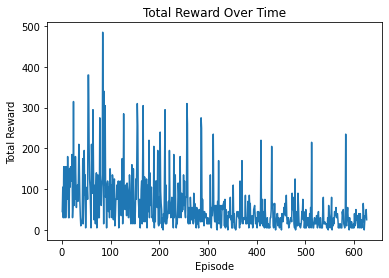

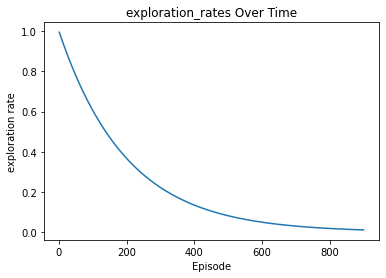

900


In [ ]:
import pickle
import matplotlib.pyplot as plt

# Plot the total reward over time
plt.plot(range(1, len(rewards)+1), rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward Over Time")
plt.show()


# Plot the exploration rate over time
plt.plot(range(1, len(exploration_rates)+1), exploration_rates)
plt.xlabel("Episode")
plt.ylabel("exploration rate")
plt.title("exploration_rates Over Time")
plt.show()

print(episode)

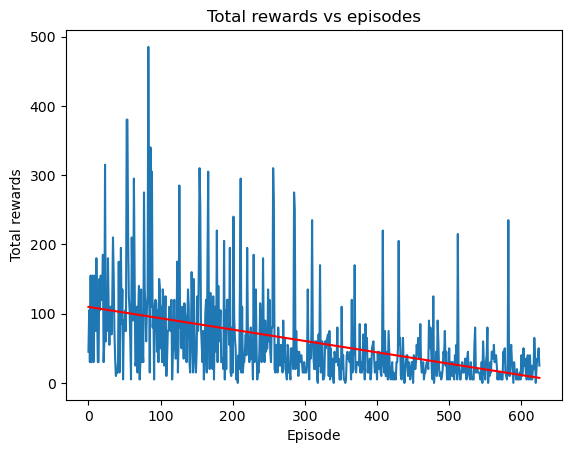

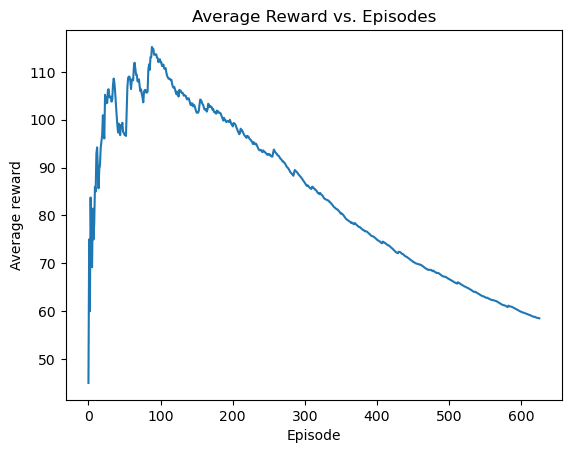

Average reward per epsiode 58.50


In [4]:
import pickle

with open('b_dqn_total_reward_space.pkl', 'rb') as f:
    rewards = pickle.load(f)
    
import numpy as np
import matplotlib.pyplot as plt


def plotting(values,name):
    episodes=np.arange(len(values))
    slope,intercept=np.polyfit(episodes,values,1)
    plt.plot(values)
    plt.plot(episodes,slope*episodes+intercept,color='red')
    plt.xlabel("Episode")
    plt.ylabel(f"Total {name}")
    plt.title(f"Total {name} vs episodes")
    plt.show()
    
plotting(rewards, 'rewards')

# Calculate and plot the average reward over time
avg_rewards = []
avg_rewards.append(rewards[0])
for i in range(1, len(rewards)):
    avg_rewards.append((avg_rewards[-1]*i + rewards[i])/(i+1))
avg_reward = sum(rewards) / len(rewards)

plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.title("Average Reward vs. Episodes")
plt.show()

print("Average reward per epsiode {:.2f}".format(avg_reward))

In [ ]:
import random
import numpy as np
import tensorflow as tf
from collections import deque
from gym import wrappers
import gym
import pickle
import datetime


print("code start time {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
# exploration_rate = exploration_rates[-1]
# Hyperparameters
learning_rate = 0.01
discount_factor = 0.99
exploration_max = 1.0
exploration_min = 0.01
exploration_decay = 0.875 

# Initialize the environment
env = gym.make('SpaceInvaders-v4', full_action_space=False,)

# Neural Network Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 8, 4, input_shape=(110, 84, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 4, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, 1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(env.action_space.n, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

# Memory
memory_size = 10000
memory = deque(maxlen=memory_size)

# preprocess the frame
def preprocess_frame(frame):
    gray = tf.image.rgb_to_grayscale(frame)
    resized = tf.image.resize(gray, [110, 84])
    return np.array(resized)

# choose the next action
def choose_action(state, exploration_rate):
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])

# store the experience in the memory
def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

#learn from the experiences
def experience_replay(batch_size):
    if len(memory) < batch_size:
        return
    samples = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in samples:
        q_update = reward
        if not done:
            next_state = next_state.reshape(1, 110, 84, 4)
            q_update = (reward + discount_factor * np.amax(model.predict(next_state, verbose=0)[0]))
        state = state.reshape(1, 110, 84, 4)
        q_values = model.predict(state, verbose=0)
        q_values[0][action] = q_update
    print("model fit  experience replay")
    model.fit(state, q_values, verbose=0)

# update the exploration rate
def update_exploration_rate(exploration_rate):
    return max(exploration_min, exploration_rate * exploration_decay)

# Training
total_steps = 0
exploration_rate = exploration_max
# List to store total rewards for each episode
rewards = []

# List to store exploration rate for each episode
exploration_rates = []

# Warm-up period
# Collect experiences without learning from them until the memory buffer is filled
print("start memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

for i in range(memory_size):
  
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0

    while not done:
        action = choose_action(state.reshape(1, 110, 84, 4), exploration_max)
        next_state, reward, done,_ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(110, 84, 1), state[:, :, :3].reshape(110, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1

        if len(memory) == memory_size:
            print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
            break
            
    if len(memory) == memory_size:
        print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
        break

for episode in range(1, 5000):
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0
    
    while not done:
        action = choose_action(state.reshape(1, 110, 84, 4), exploration_rate)
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(110, 84, 1), state[:, :, :3].reshape(110, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1
        
    exploration_rate = update_exploration_rate(exploration_rate)        
    print("Episode: {}/{}, Exploration rate: {:.4f}, Total reward: {}".format(episode, 5000, exploration_rate, total_reward))

    # Append the total reward and exploration rate for this episode to the respective lists
    experience_replay(batch_size=128) 
    rewards.append(total_reward)
    exploration_rates.append(exploration_rate)
        
    if episode % 50 == 0:
      # Save the weights
          model.save_weights('/content/drive/MyDrive/c_dqn_weights_space.h5'.format(episode))
          with open('/content/drive/MyDrive/c_dqn_memory.pkl', 'wb') as f:
              pickle.dump(memory, f)
          with open('/content/drive/MyDrive/c_dqn_exploration_rate_space.pkl'.format(episode), 'wb') as f:
              pickle.dump(exploration_rates, f)
          with open('/content/drive/MyDrive/c_dqn_total_reward_space.pkl'.format(episode), 'wb') as f:
              pickle.dump(rewards, f)
          with open('/content/drive/MyDrive/c_dqn_episode.pkl', 'wb') as f:
              pickle.dump(episode, f)

    tf.keras.backend.clear_session()

    env.close()


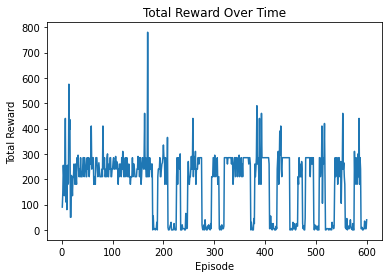

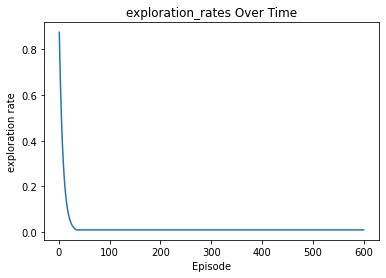

600


In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load saved variables

with open('/content/drive/MyDrive/c_dqn_episode.pkl', 'rb') as f:
    episode = pickle.load(f)
with open('/content/drive/MyDrive/c_dqn_exploration_rate_space.pkl', 'rb') as f:
    exploration_rates = pickle.load(f)
with open('/content/drive/MyDrive/c_dqn_total_reward_space.pkl', 'rb') as f:
    rewards = pickle.load(f)

# Plot the total reward over time
plt.plot(range(1, len(rewards)+1), rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward Over Time")
plt.show()


# Plot the exploration rate over time
plt.plot(range(1, len(exploration_rates)+1), exploration_rates)
plt.xlabel("Episode")
plt.ylabel("exploration rate")
plt.title("exploration_rates Over Time")
plt.show()

print(episode)

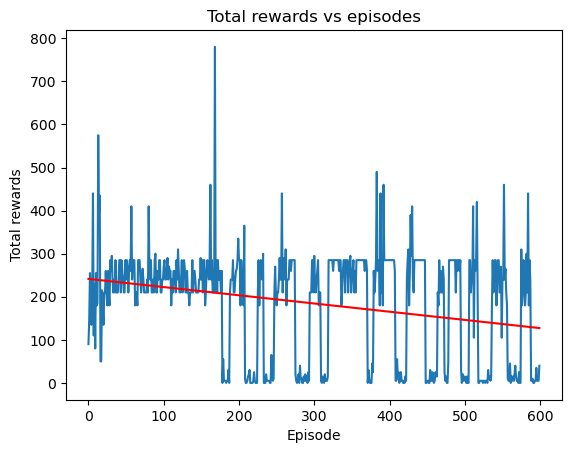

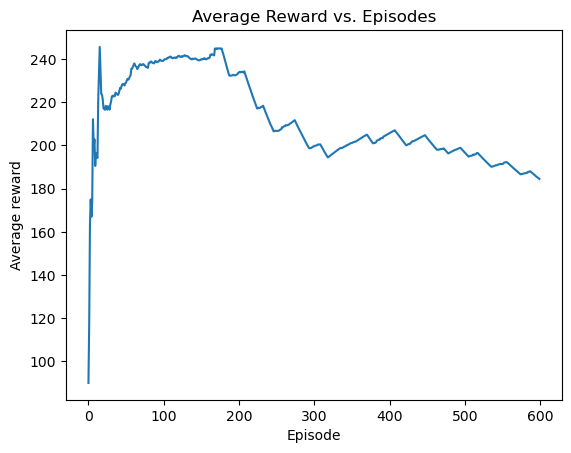

Average reward per epsiode 184.47


In [5]:
import pickle

with open('c_dqn_total_reward_space.pkl', 'rb') as f:
    rewards = pickle.load(f)
    
import numpy as np
import matplotlib.pyplot as plt


def plotting(values,name):
    episodes=np.arange(len(values))
    slope,intercept=np.polyfit(episodes,values,1)
    plt.plot(values)
    plt.plot(episodes,slope*episodes+intercept,color='red')
    plt.xlabel("Episode")
    plt.ylabel(f"Total {name}")
    plt.title(f"Total {name} vs episodes")
    plt.show()
    
plotting(rewards, 'rewards')

# Calculate and plot the average reward over time
avg_rewards = []
avg_rewards.append(rewards[0])
for i in range(1, len(rewards)):
    avg_rewards.append((avg_rewards[-1]*i + rewards[i])/(i+1))
avg_reward = sum(rewards) / len(rewards)

plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.title("Average Reward vs. Episodes")
plt.show()

print("Average reward per epsiode {:.2f}".format(avg_reward))

As can be seen the average reward per episode increased based off the suggestions from my peers, however a familiar issue is occuring. Once the agent has been training for 200 episodes, instability kicks in and the total rewards start swinging from highs of 400 to lows of 15, my assumption based on this was that the experince replay was not effectively implemented so below you will see my implementation of prioritsed experince replay based off recent research findings

#  Advanced DQN Agent implementation
##  Prioritised Experience Replay


In [ ]:
import random
import numpy as np
import tensorflow as tf
from collections import deque
from gym import wrappers
import gym
import pickle
import datetime


print("code start time {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
# exploration_rate = exploration_rates[-1]
# Hyperparameters
learning_rate = 0.01
discount_factor = 0.99
exploration_max = 1.0
exploration_min = 0.025
exploration_decay = 0.9733 


# Initialize the environment
env = gym.make('SpaceInvaders-v4', full_action_space=False,)

# Neural Network Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 8, 4, input_shape=(110, 84, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 4, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, 1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(env.action_space.n, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

# Memory
memory_size = 10000
memory = deque(maxlen=memory_size)

# preprocess the frame
def preprocess_frame(frame):
    gray = tf.image.rgb_to_grayscale(frame)
    resized = tf.image.resize(gray, [110, 84])
    return np.array(resized)

# choose the next action
def choose_action(state, exploration_rate):
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])

# store the experience in the memory
def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# learn from the experiences
def experience_replay(batch_size):
    if len(memory) < batch_size:
        return
    samples = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in samples:
        q_update = reward
        if not done:
            next_state = next_state.reshape(1, 110, 84, 4)
            q_update = (reward + discount_factor * np.amax(model.predict(next_state, verbose=0)[0]))
        state = state.reshape(1, 110, 84, 4)
        q_values = model.predict(state, verbose=0)
        q_values[0][action] = q_update
    print("model fit  experience replay")
    model.fit(state, q_values, verbose=0)

# update the exploration rate
def update_exploration_rate(exploration_rate):
    return max(exploration_min, exploration_rate * exploration_decay)

# Training
total_steps = 0
exploration_rate = exploration_max
# List to store total rewards for each episode
rewards = []

# List to store exploration rate for each episode
exploration_rates = []

# Warm-up period
# Collect experiences without learning from them until the memory buffer is filled
print("start memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

for i in range(memory_size):
  
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0

    while not done:
        action = choose_action(state.reshape(1, 110, 84, 4), exploration_max)
        next_state, reward, done,_ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(110, 84, 1), state[:, :, :3].reshape(110, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1

        if len(memory) == memory_size:
            print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
            break
            
    if len(memory) == memory_size:
        print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
        break


selected_episodes = []
selected_episode_memories = {}
num_iterations = 15
episodes_per_iteration = 15
replay_batch_size = 128

for i in range(num_iterations):
  print("Iteration: {}".format(i + 1))

  if i > 0:
    # Select episodes with highest total reward
    sorted_rewards = sorted(rewards, reverse=True)
    selected_episodes = [rewards.index(r) for r in sorted_rewards[:episodes_per_iteration]]



for episode in range(1, 5000):
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0
    
    while not done:
        action = choose_action(state.reshape(1, 110, 84, 4), exploration_rate)
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(110, 84, 1), state[:, :, :3].reshape(110, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1
        
    exploration_rate = update_exploration_rate(exploration_rate)        
    print("Episode: {}/{}, Exploration rate: {:.4f}, Total reward: {}".format(episode, 5000, exploration_rate, total_reward))

    # Append the total reward and exploration rate for this episode to the respective lists
    experience_replay(batch_size=128) 
    rewards.append(total_reward)
    exploration_rates.append(exploration_rate)

    # Update selected episodes
    if len(rewards) >= episodes_per_iteration:
        sorted_rewards = sorted(rewards, reverse=True)
        new_selected_episodes = [rewards.index(r) for r in sorted_rewards[:episodes_per_iteration]]
        if new_selected_episodes != selected_episodes:
            selected_episodes = new_selected_episodes
            print("Selected episodes updated. Rewards: {}".format(sorted_rewards[:episodes_per_iteration]))        

        
    if episode % 50 == 0:
      # Save the weights
          model.save_weights('/content/drive/MyDrive/d_dqn_weights_space.h5'.format(episode))

          # Save the selected episodes
          for episode_idx in selected_episodes:
              episode_memory = list(memory)[episode_idx*1000: (episode_idx*1000 + 1000)]
              selected_episode_memories[episode_idx] = episode_memory
              
          with open('d_selected_episode_memories.pkl', 'wb') as f:
              pickle.dump(selected_episode_memories, f)
          with open('d_selected_episodes.pkl', 'wb') as f:
              pickle.dump(selected_episodes, f)
          with open('/content/drive/MyDrive/d_dqn_exploration_rate_space.pkl'.format(episode), 'wb') as f:
              pickle.dump(exploration_rates, f)
          with open('/content/drive/MyDrive/d_dqn_total_reward_space.pkl'.format(episode), 'wb') as f:
              pickle.dump(rewards, f)
          with open('/content/drive/MyDrive/d_dqn_episode.pkl', 'wb') as f:
              pickle.dump(episode, f)

    # Perform experience replay
    if i > 0 and episode % episodes_per_iteration == 0:
        print("Experience replay")

        for i in range(replay_batch_size):
            if len(selected_episodes) > 0:
                episode_idx = random.choice(selected_episodes)
            else:
                episode_idx = random.randint(0, len(memory) - 1)
            episode_memory = list(memory)[episode_idx*1000: (episode_idx*1000 + 1000)]

            if len(episode_memory) > 0:
                samples = random.sample(episode_memory, 1)
                for state, action, reward, next_state, done in samples:
                    q_update = reward
                    if not done:
                        next_state = next_state.reshape(1, 110, 84, 4)
                        q_update = (reward + discount_factor * np.amax(model.predict(next_state, verbose=0)[0]))
                    state = state.reshape(1, 110, 84, 4)
                    q_values = model.predict(state, verbose=0)
                    q_values[0][action] = q_update
                    model.fit(state, q_values, verbose=0)

    tf.keras.backend.clear_session()


    env.close()


code start time 2023-03-09 18:46:22


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


start memory fill 2023-03-09 18:46:22


/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


End memory fill 2023-03-09 18:46:59
End memory fill 2023-03-09 18:46:59
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Episode: 1/5000, Exploration rate: 0.9733, Total reward: 270.0
model fit  experience replay
Episode: 2/5000, Exploration rate: 0.9473, Total reward: 85.0
model fit  experience replay
Episode: 3/5000, Exploration rate: 0.9220, Total reward: 65.0
model fit  experience replay
Episode: 4/5000, Exploration rate: 0.8974, Total reward: 105.0
model fit  experience replay
Episode: 5/5000, Exploration rate: 0.8734, Total reward: 75.0
model fit  experience replay
Episode: 6/5000, Exploration rate: 0.8501, Total reward: 65.0
model fit  experience replay
Episode: 7/5000, Exploration rate: 0.8274, Total reward: 110.0
model fit  experience replay
Episode: 8/5000, Exploration rate: 0.8053, Total reward: 80.0
model fit  experience rep

KeyboardInterrupt: ignored

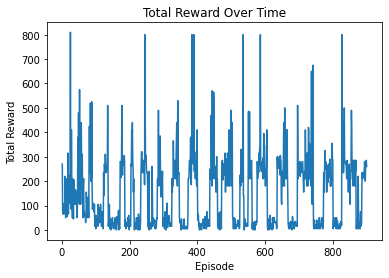

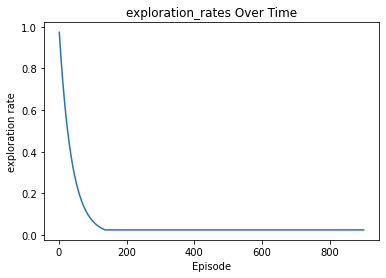

900


In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load saved variables

with open('/content/drive/MyDrive/d_dqn_episode.pkl', 'rb') as f:
    episode = pickle.load(f)
with open('/content/drive/MyDrive/d_dqn_exploration_rate_space.pkl', 'rb') as f:
    exploration_rates = pickle.load(f)
with open('/content/drive/MyDrive/d_dqn_total_reward_space.pkl', 'rb') as f:
    rewards = pickle.load(f)

# Plot the total reward over time
plt.plot(range(1, len(rewards)+1), rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward Over Time")
plt.show()


# Plot the exploration rate over time
plt.plot(range(1, len(exploration_rates)+1), exploration_rates)
plt.xlabel("Episode")
plt.ylabel("exploration rate")
plt.title("exploration_rates Over Time")
plt.show()


print(episode)

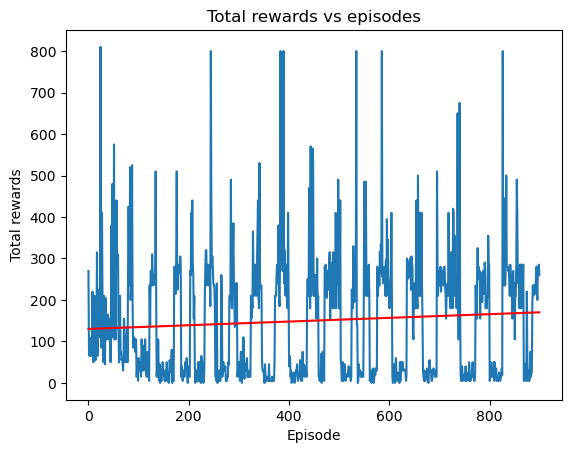

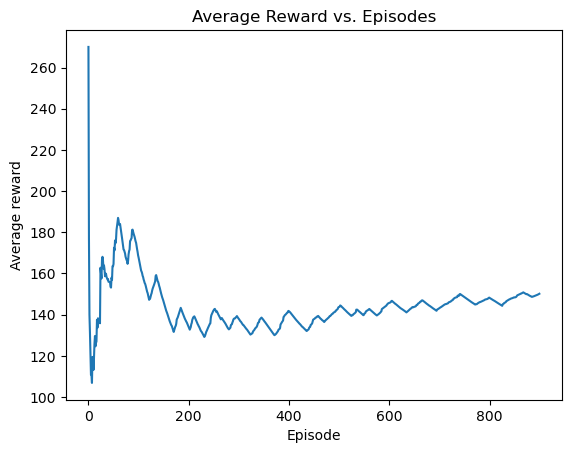

Average reward per epsiode 150.17


In [6]:
import pickle

with open('d_dqn_total_reward_space.pkl', 'rb') as f:
    rewards = pickle.load(f)
    
import numpy as np
import matplotlib.pyplot as plt


def plotting(values,name):
    episodes=np.arange(len(values))
    slope,intercept=np.polyfit(episodes,values,1)
    plt.plot(values)
    plt.plot(episodes,slope*episodes+intercept,color='red')
    plt.xlabel("Episode")
    plt.ylabel(f"Total {name}")
    plt.title(f"Total {name} vs episodes")
    plt.show()
    
plotting(rewards, 'rewards')

# Calculate and plot the average reward over time
avg_rewards = []
avg_rewards.append(rewards[0])
for i in range(1, len(rewards)):
    avg_rewards.append((avg_rewards[-1]*i + rewards[i])/(i+1))
avg_reward = sum(rewards) / len(rewards)

plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.title("Average Reward vs. Episodes")
plt.show()

print("Average reward per epsiode {:.2f}".format(avg_reward))

## Discussion

This advanced implementation relies on prioritised experience replay, where the best 15 episode are used for experience replay and this list is continually updated each time a new high score is achieved, as can be seen by the total rewards plot the agent does seem to be continually achiving a high score of 800 points indicating that it is achieving higher scores than previous implementations and more frquently, what is noteable however is that the model begins performing inconsistently over time where it will frquently have several runs where it acheives low scores before hitting a high score again, there could be many reasons for this and most likely it is a combination of things, due to the complexity of the game it is likely a game that would require thousands of episodes to learn a strong policy and it seems that prioritised learning is only one piece of the puzzle needed to improve it's score.

Despite the less than optimal consistency we see that in fact the learning rate indicated by the red line shows and upward trend indicating improvement in average rewards over time, showing that it is learning better than the previous implementations

In this task due to the long training time I will not be able to get another advanced implementation of a DQN agent completed before the deadline, but it is something I will be doing in the future, I'm sure if I added prioritised learning and double DQN I could get much better results, as this would lead lead to more efficient and stable learning.


## Lightweight experiment examining impact of varying hyper-parameters

As space invaders is quite a difficult game to learn from in terms of training time, on the advice of one of my peers I am choosing Atlantis for the task 4 analysis and only training for a 100 epsisodes for each hyperparamter configuration.

The available hyperparamters which we have to change are Learning rate, Discount Factor, Exploration Decay rate, Memory Size, and Batch size. We will only be focusing on the first 3 with memory sixed fixed and a batch size of 32 used.

The exploration rate determines the probability of the agent taking random actions rather than following its policy. A high exploration rate can lead to more exploration but less exploitation of the learned policy, while a low exploration rate can lead to the agent getting stuck in suboptimal policies. Exploration rate has been shown to have significant impact on performance. 
Chosen exploration_decay rates:  0.875 , 0.999

The learning rate determines the step size at each iteration while updating the weights of the neural network. A high learning rate can cause the model to overshoot the optimal solution, while a low learning rate can lead to slow convergence. 
Chosen Learning rates: 0.01, 0.1 

The discount factor determines the importance of future rewards in the agent's decision-making process. A high discount factor means the agent values long-term rewards more, while a low discount factor means the agent prioritizes immediate rewards.
Chosen discount factors: 0.99, 0.1

# Section 4 : experiment 1

In [13]:
import random
import numpy as np
import tensorflow as tf
from collections import deque
from gym import wrappers
import gym
import pickle
import datetime


print("code start time {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
# exploration_rate = exploration_rates[-1]
# Hyperparameters
learning_rate = 0.01
discount_factor = 0.99
exploration_max = 1.0
exploration_min = 0.01
exploration_decay = 0.875 

# Initialize the environment
env = gym.make('Atlantis-v4', full_action_space=False,)

# Neural Network Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 8, 4, input_shape=(84, 84, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 4, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, 1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(env.action_space.n, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

# Memory
memory_size = 10000
memory = deque(maxlen=memory_size)

# preprocess the frame
def preprocess_frame(frame):
    gray = tf.image.rgb_to_grayscale(frame)
    resized = tf.image.resize(gray, [84, 84])
    return np.array(resized)

# choose the next action
def choose_action(state, exploration_rate):
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])

# store the experience in the memory
def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

#learn from the experiences
def experience_replay(batch_size):
    if len(memory) < batch_size:
        return
    samples = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in samples:
        q_update = reward
        if not done:
            next_state = next_state.reshape(1, 84, 84, 4)
            q_update = (reward + discount_factor * np.amax(model.predict(next_state, verbose=0)[0]))
        state = state.reshape(1, 84, 84, 4)
        q_values = model.predict(state, verbose=0)
        q_values[0][action] = q_update
    print("model fit  experience replay")
    model.fit(state, q_values, verbose=0)

# update the exploration rate
def update_exploration_rate(exploration_rate):
    return max(exploration_min, exploration_rate * exploration_decay)

# Training
total_steps = 0
exploration_rate = exploration_max
# List to store total rewards for each episode
rewards = []

# List to store exploration rate for each episode
exploration_rates = []

# Warm-up period
# Collect experiences without learning from them until the memory buffer is filled
print("start memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

for i in range(memory_size):
  
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0

    while not done:
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_max)
        next_state, reward, done,_ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1

        if len(memory) == memory_size:
            print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
            break
            
    if len(memory) == memory_size:
        print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
        break

for episode in range(1, 100):
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0
    
    while not done:
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_rate)
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1
        
    exploration_rate = update_exploration_rate(exploration_rate)        
    print("Episode: {}/{}, Exploration rate: {:.4f}, Total reward: {}".format(episode, 100, exploration_rate, total_reward))

    # Append the total reward and exploration rate for this episode to the respective lists
    experience_replay(batch_size=32) 
    rewards.append(total_reward)
    exploration_rates.append(exploration_rate)
        

    tf.keras.backend.clear_session()

    env.close()


code start time 2023-03-12 13:34:07
start memory fill 2023-03-12 13:34:07
End memory fill 2023-03-12 13:34:42
End memory fill 2023-03-12 13:34:42
Episode: 1/100, Exploration rate: 0.8750, Total reward: 17800.0
model fit  experience replay
Episode: 2/100, Exploration rate: 0.7656, Total reward: 13600.0
model fit  experience replay
Episode: 3/100, Exploration rate: 0.6699, Total reward: 9400.0
model fit  experience replay
Episode: 4/100, Exploration rate: 0.5862, Total reward: 14700.0
model fit  experience replay
Episode: 5/100, Exploration rate: 0.5129, Total reward: 6700.0
model fit  experience replay
Episode: 6/100, Exploration rate: 0.4488, Total reward: 11700.0
model fit  experience replay
Episode: 7/100, Exploration rate: 0.3927, Total reward: 6300.0
model fit  experience replay
Episode: 8/100, Exploration rate: 0.3436, Total reward: 6900.0
model fit  experience replay
Episode: 9/100, Exploration rate: 0.3007, Total reward: 6800.0
model fit  experience replay
Episode: 10/100, Explo

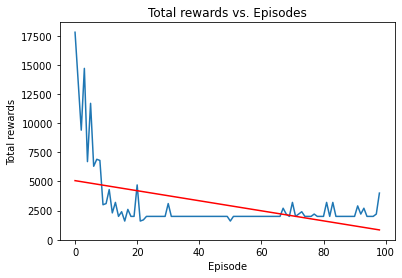

The slope is -43.1403834260977 and the intercept is 5067.414141414142


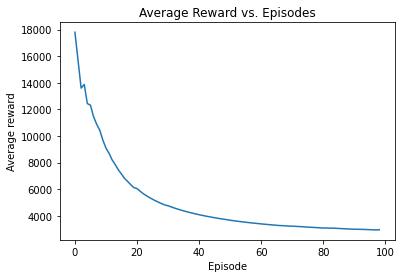

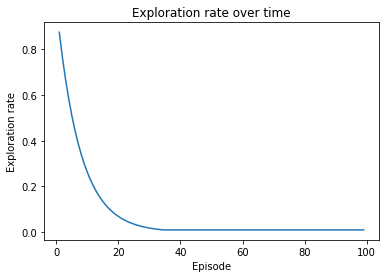

Experiment 1
Episode: 99, Learning Rate: 0.01, Discount Factor: 0.99, Exploration Decay: 0.875, Average reward: 2953.54


In [17]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plotting(values, name):
    episodes = np.arange(len(values))
    slope, intercept = np.polyfit(episodes, values, 1)
    plt.plot(values)
    plt.plot(episodes, slope*episodes + intercept, color='red')
    plt.xlabel("Episode")
    plt.ylabel(f"Total {name}")
    plt.title(f"Total {name} vs. Episodes")
    plt.show()
    print(f"The slope is {slope} and the intercept is {intercept}")

# Calculate the average reward over all episodes
avg_reward = sum(rewards) / len(rewards)

# Plot the total rewards over time
plotting(rewards, 'rewards')

# Calculate and plot the average reward over time
avg_rewards = []
avg_rewards.append(rewards[0])
for i in range(1, len(rewards)):
    avg_rewards.append((avg_rewards[-1]*i + rewards[i])/(i+1))
avg_reward = sum(rewards) / len(rewards)

plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.title("Average Reward vs. Episodes")
plt.show()

# Plot the exploration rate over time
plt.plot(range(1, len(exploration_rates)+1), exploration_rates)
plt.xlabel("Episode")
plt.ylabel("Exploration rate")
plt.title("Exploration rate over time")
plt.show()

# Print the hyperparameters
print("Experiment 1")
print("Episode: {}, Learning Rate: {}, Discount Factor: {}, Exploration Decay: {}, Average reward: {:.2f}".format(episode, learning_rate, discount_factor, exploration_decay, avg_reward))


<!-- NOTEBOOK HEADINGS LINKS
1. [My Heading](#unique-id)
 -->

### Observations
From Experiment 1, we can see that the agent has learned to achieve an average reward of 2953.54 over 99 episodes using a learning rate of 0.01, discount factor of 0.99, and exploration decay of 0.875. AS we can see the agent starts out performing quite well when the exploration rate is high and then begins to have a sharpy drop in performance reamining at a reward level of 2000 for most of the episodes before a a few minor increase in rewards towards the end. Here we see the negative influence of a high rate of exploration rate decay, as the agent has clearly learned a suboptimal policy

# Section 4 : Experiment 2

In [2]:
import random
import numpy as np
import tensorflow as tf
from collections import deque
from gym import wrappers
import gym
import pickle
import datetime


print("code start time {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
# exploration_rate = exploration_rates[-1]
# Hyperparameters
learning_rate = 0.01
discount_factor = 0.99
exploration_max = 1.0
exploration_min = 0.01
exploration_decay = 0.999 

# Initialize the environment
env = gym.make('Atlantis-v4', full_action_space=False,)

# Neural Network Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 8, 4, input_shape=(84, 84, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 4, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, 1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(env.action_space.n, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

# Memory
memory_size = 10000
memory = deque(maxlen=memory_size)

# preprocess the frame
def preprocess_frame(frame):
    gray = tf.image.rgb_to_grayscale(frame)
    resized = tf.image.resize(gray, [84, 84])
    return np.array(resized)

# choose the next action
def choose_action(state, exploration_rate):
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])

# store the experience in the memory
def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

#learn from the experiences
def experience_replay(batch_size):
    if len(memory) < batch_size:
        return
    samples = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in samples:
        q_update = reward
        if not done:
            next_state = next_state.reshape(1, 84, 84, 4)
            q_update = (reward + discount_factor * np.amax(model.predict(next_state, verbose=0)[0]))
        state = state.reshape(1, 84, 84, 4)
        q_values = model.predict(state, verbose=0)
        q_values[0][action] = q_update
    print("model fit  experience replay")
    model.fit(state, q_values, verbose=0)

# update the exploration rate
def update_exploration_rate(exploration_rate):
    return max(exploration_min, exploration_rate * exploration_decay)

# Training
total_steps = 0
exploration_rate = exploration_max
# List to store total rewards for each episode
rewards = []

# List to store exploration rate for each episode
exploration_rates = []

# Warm-up period
# Collect experiences without learning from them until the memory buffer is filled
print("start memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

for i in range(memory_size):
  
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0

    while not done:
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_max)
        next_state, reward, done,_ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1

        if len(memory) == memory_size:
            print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
            break
            
    if len(memory) == memory_size:
        print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
        break

for episode in range(1, 100):
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0
    
    while not done:
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_rate)
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1
        
    exploration_rate = update_exploration_rate(exploration_rate)        
    print("Episode: {}/{}, Exploration rate: {:.4f}, Total reward: {}".format(episode, 100, exploration_rate, total_reward))

    # Append the total reward and exploration rate for this episode to the respective lists
    experience_replay(batch_size=32) 
    rewards.append(total_reward)
    exploration_rates.append(exploration_rate)
        

    tf.keras.backend.clear_session()

    env.close()


code start time 2023-03-12 14:41:27


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


start memory fill 2023-03-12 14:41:29


/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


End memory fill 2023-03-12 14:42:07
End memory fill 2023-03-12 14:42:07
Episode: 1/100, Exploration rate: 0.9990, Total reward: 11100.0
model fit  experience replay
Episode: 2/100, Exploration rate: 0.9980, Total reward: 18000.0
model fit  experience replay
Episode: 3/100, Exploration rate: 0.9970, Total reward: 20900.0
model fit  experience replay
Episode: 4/100, Exploration rate: 0.9960, Total reward: 20900.0
model fit  experience replay
Episode: 5/100, Exploration rate: 0.9950, Total reward: 13800.0
model fit  experience replay
Episode: 6/100, Exploration rate: 0.9940, Total reward: 24500.0
model fit  experience replay
Episode: 7/100, Exploration rate: 0.9930, Total reward: 13400.0
model fit  experience replay
Episode: 8/100, Exploration rate: 0.9920, Total reward: 18000.0
model fit  experience replay
Episode: 9/100, Exploration rate: 0.9910, Total reward: 26900.0
model fit  experience replay
Episode: 10/100, Exploration rate: 0.9900, Total reward: 17400.0
model fit  experience repl

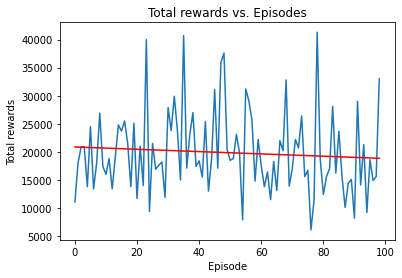

The slope is -20.59 and the intercept is 20871.54


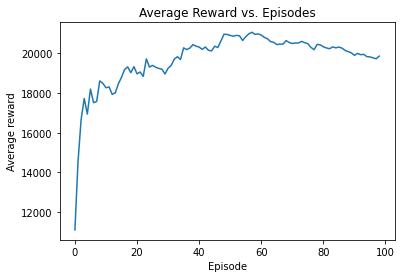

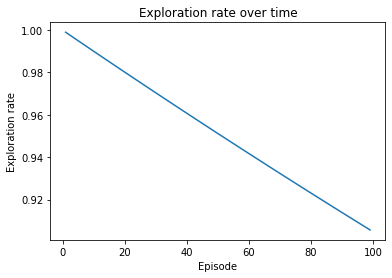

Experiment 2
Episode: 99, Learning Rate: 0.01, Discount Factor: 0.99, Exploration Decay: 0.999, Average reward: 19862.63


In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plotting(values, name):
    episodes = np.arange(len(values))
    slope, intercept = np.polyfit(episodes, values, 1)
    plt.plot(values)
    plt.plot(episodes, slope*episodes + intercept, color='red')
    plt.xlabel("Episode")
    plt.ylabel(f"Total {name}")
    plt.title(f"Total {name} vs. Episodes")
    plt.show()
    print("The slope is {:.2f} and the intercept is {:.2f}".format(slope,intercept))
# Calculate the average reward over all episodes
avg_reward = sum(rewards) / len(rewards)

# Plot the total rewards over time
plotting(rewards, 'rewards')

# Calculate and plot the average reward over time
avg_rewards = []
avg_rewards.append(rewards[0])
for i in range(1, len(rewards)):
    avg_rewards.append((avg_rewards[-1]*i + rewards[i])/(i+1))
avg_reward = sum(rewards) / len(rewards)

plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.title("Average Reward vs. Episodes")
plt.show()

# Plot the exploration rate over time
plt.plot(range(1, len(exploration_rates)+1), exploration_rates)
plt.xlabel("Episode")
plt.ylabel("Exploration rate")
plt.title("Exploration rate over time")
plt.show()

# Print the hyperparameters
print("Experiment 2")
print("Episode: {}, Learning Rate: {}, Discount Factor: {}, Exploration Decay: {}, Average reward: {:.2f}".format(episode, learning_rate, discount_factor, exploration_decay, avg_reward))


### Observations
In Experiment 2, the agent was trained with the same learning rate and discount factor as in Experiment 1, but with a slower exploration rate decay of 0.999. The average reward achieved in Experiment 2 was much higher than that in Experiment 1, with an average reward of 19862.63 compared to 2953.54 in Experiment 1. This suggests that the slower exploration rate decay allowed the agent to explore more and discover better strategies for maximizing the reward. This is because slower exploration decay means the agent is more likely to continue exploring even after it has learned a good policy, which can lead to the discovery of better policies.


# Section 4 : Experiment 3

<!-- NOTEBOOK HEADINGS LINKS
1. [My Heading](#unique-id)
 -->

In [2]:
import random
import numpy as np
import tensorflow as tf
from collections import deque
from gym import wrappers
import gym
import pickle
import datetime


print("code start time {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
# exploration_rate = exploration_rates[-1]
# Hyperparameters
learning_rate = 0.1
discount_factor = 0.99
exploration_max = 1.0
exploration_min = 0.01
exploration_decay = 0.999 

# Initialize the environment
env = gym.make('Atlantis-v4', full_action_space=False,)

# Neural Network Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 8, 4, input_shape=(84, 84, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 4, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, 1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(env.action_space.n, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

# Memory
memory_size = 10000
memory = deque(maxlen=memory_size)

# preprocess the frame
def preprocess_frame(frame):
    gray = tf.image.rgb_to_grayscale(frame)
    resized = tf.image.resize(gray, [84, 84])
    return np.array(resized)

# choose the next action
def choose_action(state, exploration_rate):
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])

# store the experience in the memory
def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

#learn from the experiences
def experience_replay(batch_size):
    if len(memory) < batch_size:
        return
    samples = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in samples:
        q_update = reward
        if not done:
            next_state = next_state.reshape(1, 84, 84, 4)
            q_update = (reward + discount_factor * np.amax(model.predict(next_state, verbose=0)[0]))
        state = state.reshape(1, 84, 84, 4)
        q_values = model.predict(state, verbose=0)
        q_values[0][action] = q_update
    print("model fit  experience replay")
    model.fit(state, q_values, verbose=0)

# update the exploration rate
def update_exploration_rate(exploration_rate):
    return max(exploration_min, exploration_rate * exploration_decay)

# Training
total_steps = 0
exploration_rate = exploration_max
# List to store total rewards for each episode
rewards = []

# List to store exploration rate for each episode
exploration_rates = []

# Warm-up period
# Collect experiences without learning from them until the memory buffer is filled
print("start memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

for i in range(memory_size):
  
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0

    while not done:
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_max)
        next_state, reward, done,_ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1

        if len(memory) == memory_size:
            print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
            break
            
    if len(memory) == memory_size:
        print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
        break

for episode in range(1, 101):
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0
    
    while not done:
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_rate)
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1
        
    exploration_rate = update_exploration_rate(exploration_rate)        
    print("Episode: {}/{}, Exploration rate: {:.4f}, Total reward: {}".format(episode, 100, exploration_rate, total_reward))

    # Append the total reward and exploration rate for this episode to the respective lists
    experience_replay(batch_size=32) 
    rewards.append(total_reward)
    exploration_rates.append(exploration_rate)
        

    tf.keras.backend.clear_session()

    env.close()


code start time 2023-03-12 15:13:06


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


start memory fill 2023-03-12 15:13:08


/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


End memory fill 2023-03-12 15:13:47
End memory fill 2023-03-12 15:13:47
Episode: 1/100, Exploration rate: 0.9990, Total reward: 33700.0
model fit  experience replay
Episode: 2/100, Exploration rate: 0.9980, Total reward: 24600.0
model fit  experience replay
Episode: 3/100, Exploration rate: 0.9970, Total reward: 18100.0
model fit  experience replay
Episode: 4/100, Exploration rate: 0.9960, Total reward: 22900.0
model fit  experience replay
Episode: 5/100, Exploration rate: 0.9950, Total reward: 13900.0
model fit  experience replay
Episode: 6/100, Exploration rate: 0.9940, Total reward: 11500.0
model fit  experience replay
Episode: 7/100, Exploration rate: 0.9930, Total reward: 19200.0
model fit  experience replay
Episode: 8/100, Exploration rate: 0.9920, Total reward: 16700.0
model fit  experience replay
Episode: 9/100, Exploration rate: 0.9910, Total reward: 27600.0
model fit  experience replay
Episode: 10/100, Exploration rate: 0.9900, Total reward: 17400.0
model fit  experience repl

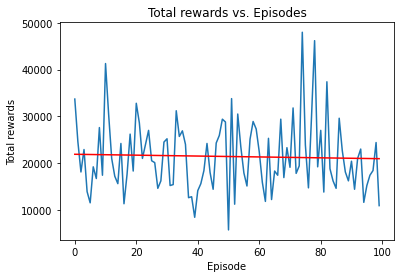

The slope is -9.50 and the intercept is 21886.08


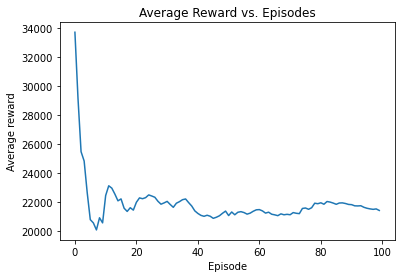

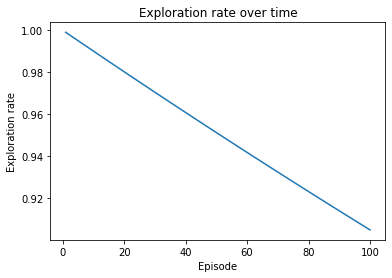

Experiment 3
Episode: 100, Learning Rate: 0.1, Discount Factor: 0.99, Exploration Decay: 0.999, Average reward: 21416.00


In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plotting(values, name):
    episodes = np.arange(len(values))
    slope, intercept = np.polyfit(episodes, values, 1)
    plt.plot(values)
    plt.plot(episodes, slope*episodes + intercept, color='red')
    plt.xlabel("Episode")
    plt.ylabel(f"Total {name}")
    plt.title(f"Total {name} vs. Episodes")
    plt.show()
    print("The slope is {:.2f} and the intercept is {:.2f}".format(slope,intercept))
# Calculate the average reward over all episodes
avg_reward = sum(rewards) / len(rewards)

# Plot the total rewards over time
plotting(rewards, 'rewards')

# Calculate and plot the average reward over time
avg_rewards = []
avg_rewards.append(rewards[0])
for i in range(1, len(rewards)):
    avg_rewards.append((avg_rewards[-1]*i + rewards[i])/(i+1))
avg_reward = sum(rewards) / len(rewards)

plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.title("Average Reward vs. Episodes")
plt.show()

# Plot the exploration rate over time
plt.plot(range(1, len(exploration_rates)+1), exploration_rates)
plt.xlabel("Episode")
plt.ylabel("Exploration rate")
plt.title("Exploration rate over time")
plt.show()

# Print the hyperparameters
print("Experiment 3")
print("Episode: {}, Learning Rate: {}, Discount Factor: {}, Exploration Decay: {}, Average reward: {:.2f}".format(episode, learning_rate, discount_factor, exploration_decay, avg_reward))


### Observations
Experiment 3 has a higher learning rate of 0.1 compared to Experiment 1 and 2 which both had a learning rate of 0.01. The higher learning rate should allow the agent to learn more quickly which is useful given the 100 episode limitation in these experiments, but in the long term it would likely make the agent perform poorly by missing the optimal policy

Experiment 3 also has the same discount factor and exploration decay rate as Experiment 2, which had an average reward of 19862.63. Experiment 3 has a slightly higher average reward of 21416.00, suggesting that the higher learning rate was able to help the agent reach a slightly better policy.

We see from the red line plotting the average rewards per episode that this experiemnt has a more stable flat learning rate compared to the first two experiments. 

<!-- NOTEBOOK HEADINGS LINKS
1. [My Heading](#unique-id)
 -->

# Section 4 : Experiment 4

In [2]:
import random
import numpy as np
import tensorflow as tf
from collections import deque
from gym import wrappers
import gym
import pickle
import datetime


print("code start time {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
# exploration_rate = exploration_rates[-1]
# Hyperparameters
learning_rate = 0.1
discount_factor = 0.1
exploration_max = 1.0
exploration_min = 0.01
exploration_decay = 0.999 

# Initialize the environment
env = gym.make('Atlantis-v4', full_action_space=False,)

# Neural Network Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 8, 4, input_shape=(84, 84, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 4, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, 1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(env.action_space.n, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

# Memory
memory_size = 10000
memory = deque(maxlen=memory_size)

# preprocess the frame
def preprocess_frame(frame):
    gray = tf.image.rgb_to_grayscale(frame)
    resized = tf.image.resize(gray, [84, 84])
    return np.array(resized)

# choose the next action
def choose_action(state, exploration_rate):
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])

# store the experience in the memory
def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

#learn from the experiences
def experience_replay(batch_size):
    if len(memory) < batch_size:
        return
    samples = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in samples:
        q_update = reward
        if not done:
            next_state = next_state.reshape(1, 84, 84, 4)
            q_update = (reward + discount_factor * np.amax(model.predict(next_state, verbose=0)[0]))
        state = state.reshape(1, 84, 84, 4)
        q_values = model.predict(state, verbose=0)
        q_values[0][action] = q_update
    print("model fit  experience replay")
    model.fit(state, q_values, verbose=0)

# update the exploration rate
def update_exploration_rate(exploration_rate):
    return max(exploration_min, exploration_rate * exploration_decay)

# Training
total_steps = 0
exploration_rate = exploration_max
# List to store total rewards for each episode
rewards = []

# List to store exploration rate for each episode
exploration_rates = []

# Warm-up period
# Collect experiences without learning from them until the memory buffer is filled
print("start memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

for i in range(memory_size):
  
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0

    while not done:
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_max)
        next_state, reward, done,_ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1

        if len(memory) == memory_size:
            print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
            break
            
    if len(memory) == memory_size:
        print("End memory fill {}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
        break

for episode in range(1, 101):
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0
    
    while not done:
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_rate)
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1
        
    exploration_rate = update_exploration_rate(exploration_rate)        
    print("Episode: {}/{}, Exploration rate: {:.4f}, Total reward: {}".format(episode, 100, exploration_rate, total_reward))

    # Append the total reward and exploration rate for this episode to the respective lists
    experience_replay(batch_size=32) 
    rewards.append(total_reward)
    exploration_rates.append(exploration_rate)
        

    tf.keras.backend.clear_session()

    env.close()


code start time 2023-03-12 15:45:00


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


start memory fill 2023-03-12 15:45:02


/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


End memory fill 2023-03-12 15:45:40
End memory fill 2023-03-12 15:45:40
Episode: 1/100, Exploration rate: 0.9990, Total reward: 29200.0
model fit  experience replay
Episode: 2/100, Exploration rate: 0.9980, Total reward: 15600.0
model fit  experience replay
Episode: 3/100, Exploration rate: 0.9970, Total reward: 25500.0
model fit  experience replay
Episode: 4/100, Exploration rate: 0.9960, Total reward: 23400.0
model fit  experience replay
Episode: 5/100, Exploration rate: 0.9950, Total reward: 24200.0
model fit  experience replay
Episode: 6/100, Exploration rate: 0.9940, Total reward: 14700.0
model fit  experience replay
Episode: 7/100, Exploration rate: 0.9930, Total reward: 27000.0
model fit  experience replay
Episode: 8/100, Exploration rate: 0.9920, Total reward: 23300.0
model fit  experience replay
Episode: 9/100, Exploration rate: 0.9910, Total reward: 12500.0
model fit  experience replay
Episode: 10/100, Exploration rate: 0.9900, Total reward: 7500.0
model fit  experience repla

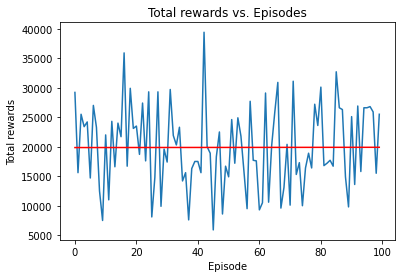

The slope is 0.46 and the intercept is 19857.07


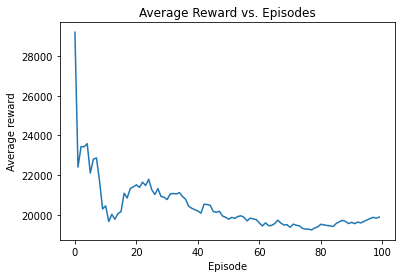

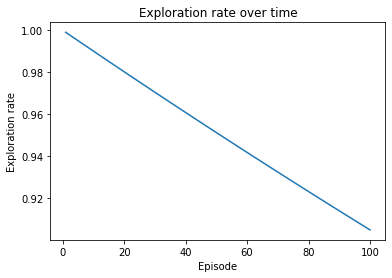

Experiment 4
Episode: 100, Learning Rate: 0.1, Discount Factor: 0.1, Exploration Decay: 0.999, Average reward: 19880.00


In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plotting(values, name):
    episodes = np.arange(len(values))
    slope, intercept = np.polyfit(episodes, values, 1)
    plt.plot(values)
    plt.plot(episodes, slope*episodes + intercept, color='red')
    plt.xlabel("Episode")
    plt.ylabel(f"Total {name}")
    plt.title(f"Total {name} vs. Episodes")
    plt.show()
    print("The slope is {:.2f} and the intercept is {:.2f}".format(slope,intercept))
# Calculate the average reward over all episodes
avg_reward = sum(rewards) / len(rewards)

# Plot the total rewards over time
plotting(rewards, 'rewards')

# Calculate and plot the average reward over time
avg_rewards = []
avg_rewards.append(rewards[0])
for i in range(1, len(rewards)):
    avg_rewards.append((avg_rewards[-1]*i + rewards[i])/(i+1))
avg_reward = sum(rewards) / len(rewards)

plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.title("Average Reward vs. Episodes")
plt.show()

# Plot the exploration rate over time
plt.plot(range(1, len(exploration_rates)+1), exploration_rates)
plt.xlabel("Episode")
plt.ylabel("Exploration rate")
plt.title("Exploration rate over time")
plt.show()

# Print the hyperparameters
print("Experiment 4")
print("Episode: {}, Learning Rate: {}, Discount Factor: {}, Exploration Decay: {}, Average reward: {:.2f}".format(episode, learning_rate, discount_factor, exploration_decay, avg_reward))


### Final Observations

From the results of the previous experiments, we can see that:

Experiment 1 (LR=0.01, DF=0.99, ED=0.875) had an average reward of 2953.54
Experiment 2 (LR=0.01, DF=0.99, ED=0.999) had an average reward of 19862.63
Experiment 3 (LR=0.1, DF=0.99, ED=0.999) had an average reward of 21416.00
Experiment 4 (LR=0.1, DF=0.1, ED=0.999) had an average reward of 19880.00

Experiment 2 had the highest average reward, followed by Experiment 3, Experiment 1, and Experiment 4. This suggests that a high exploration decay rate (Experiment 2 and 3) can be beneficial in achieving higher rewards, while a low discount factor (Experiment 4) can be detrimental to the learning process.

The biggest improvement came from changing the exploration decay rate and minor improvement came from increaseing the learning rate, we can deduce from these few experiments that we can optimise the DQN agents average rewards over 100 episodes using the following hyperparameter values:

Learning Rate - 0.1

Discount Factor - 0.99

Exploration Deacy Rate - 0.9999

It should be noted that these hyperparamters are chosen as optimal for the specific DQN implementation for the Atlantis game over a minimal(100) number of episodes, given more time to train a variety of hyperparameter combinations over hundreds to thousands of episodes these values would definitely prove to be sub optimal.

